In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data preprocessing

## Data download

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE, 
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 24s 0us/step
Found 2000 files belonging to 2 classes.


In [7]:
validation_dataset = image_dataset_from_directory(validation_dir, 
                                                  shuffle=True, 
                                                  batch_size=BATCH_SIZE, 
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Checking the first nine images and labels from training set

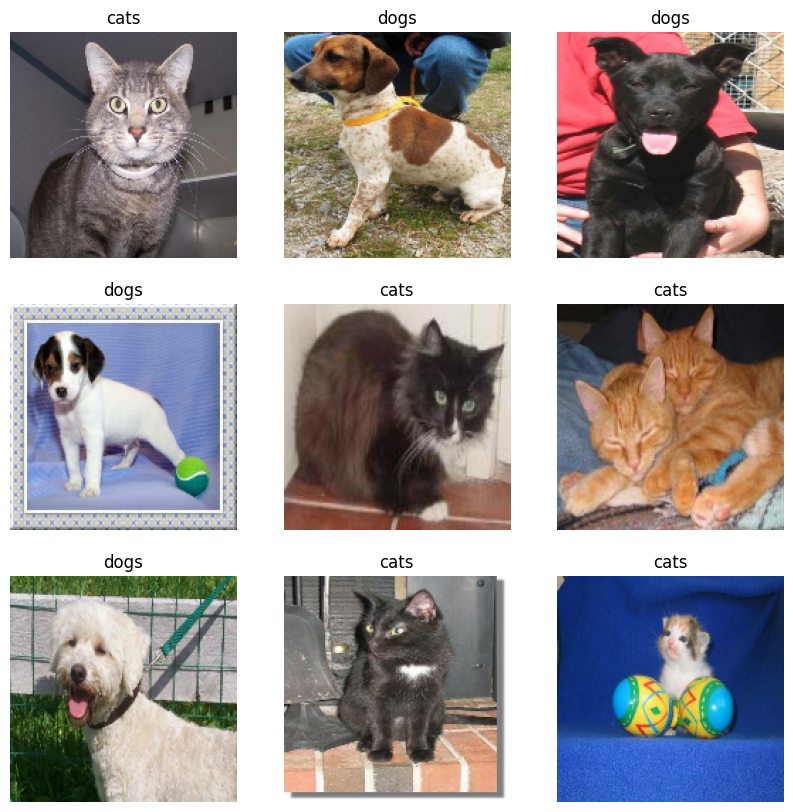

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
plt.show()

Creating a test set for the analysis. This will be done by moving 20% of the batches from the validation set

In [19]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configuring the dataset for performance

Using of buffered prefetching to load images from disk without having some I/O blocking

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Using data augmentation

Since we do not have a large dataset, we can augment the sample diversity by applying random transformations to the TRAINING images, such as rotation and translation (these transformation must still make sense to task at hand). This technique helps the model to learn different aspects of the training data and reduces the overfitting.

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'), 
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# these layers are active only during the training step, when calling model.fit.
# They are inactive when using model.evaluate

example of these transformations applied to a same image

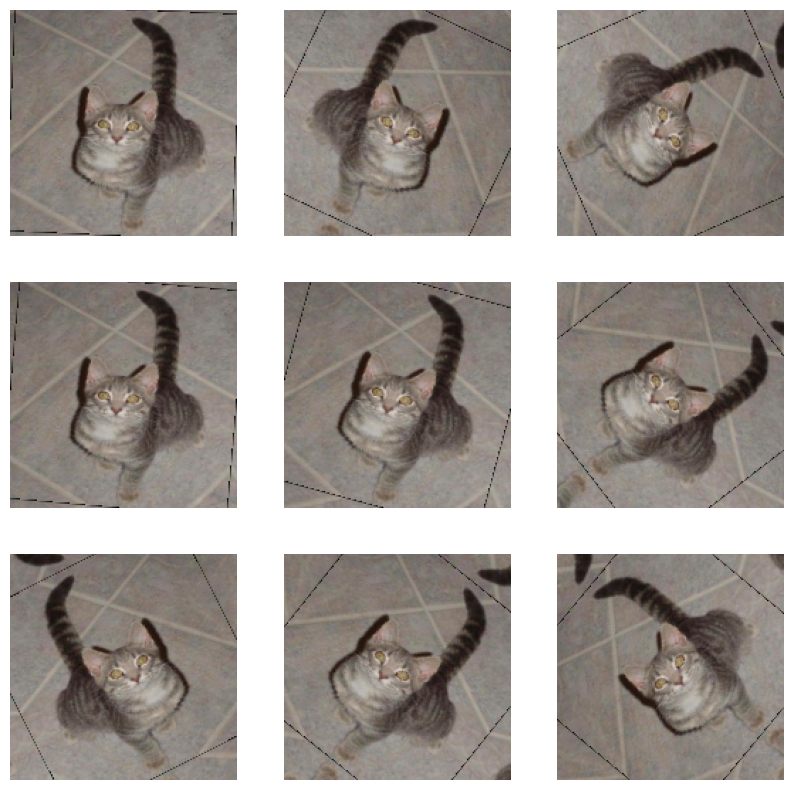

In [33]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        
plt.show();

## Rescale pixel values

changing the range of values for each pixel from [0, 255] to [-1, 1]. To do this, we use a specific set of operations related to the model which is being used (MobileNetV2)

In [34]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the base model

Here we use the pre-trained model MobileNet V2, which was trained on the ImageNet dataset. The convolution layers of this model will do the feature extraction, with the last conected layers being discarded in order to use a new set of layers for the classification of the specific task at hand

In [40]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False, 
                                               weights='imagenet')

These layers will serve as an extractor of features, transforming a 160 x 160 x 3 image into a 5 x 5 x 1280 block of features

In [42]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature Extraction

## Freezing the convolutional base

In [43]:
base_model.trainable = False

In [44]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Detail about batch normalization layers

BatchNormalization layers are a special case and need a little bit more caution. When these layers are set as non-trainable (layer.trainable = False), they will run in inference mode, not updating its meand and variance.

When unfreezing a model which contains BatchNormalization layers (in order to do a fine-tuning, for example), we should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

## Adding a classification head

To generated predictions from the block of features, we will use an average over the 5 x 5 spatial locations by means of the layer GlobalAveragePooling2D (tf.keras.layers.GlobalAveragePooling2D) 

In [45]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


We can add a tf.keras.layers.Dense layer to convert the features extracted into a single prediction for a image. Positive numbers predict class 1 and negative numbers predict class 0

In [46]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Finally, we can build the model by chaining together all the previous steps using the Keras Functional API.

In [47]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compiling the model

Since we have two classes, the binary cross-entropy loss will be used with from_logits = True, since the model provides a linear output

In [48]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

## Training the model

In [50]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 198ms/step - loss: 0.6364 - accuracy: 0.6559


In [51]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 0.64
initial accuracy: 0.66


In [52]:
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 22s 344ms/step - loss: 0.6067 - accuracy: 0.6590 - val_loss: 0.4343 - val_accuracy: 0.7723
Epoch 2/10
63/63 [==============================] - 26s 406ms/step - loss: 0.4602 - accuracy: 0.7590 - val_loss: 0.3317 - val_accuracy: 0.8527
Epoch 3/10
63/63 [==============================] - 27s 424ms/step - loss: 0.3772 - accuracy: 0.8100 - val_loss: 0.2637 - val_accuracy: 0.8923
Epoch 4/10
63/63 [==============================] - 27s 436ms/step - loss: 0.3162 - accuracy: 0.8585 - val_loss: 0.2145 - val_accuracy: 0.9233
Epoch 5/10
63/63 [==============================] - 28s 442ms/step - loss: 0.2958 - accuracy: 0.8675 - val_loss: 0.1877 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 28s 443ms/step - loss: 0.2704 - accuracy: 0.8795 - val_loss: 0.1683 - val_accuracy: 0.9554
Epoch 7/10
63/63 [==============================] - 32s 507ms/step - loss: 0.2537 - accuracy: 0.8770 - val_loss: 0.1510 - val_accuracy: 0.9616

## Learning curves

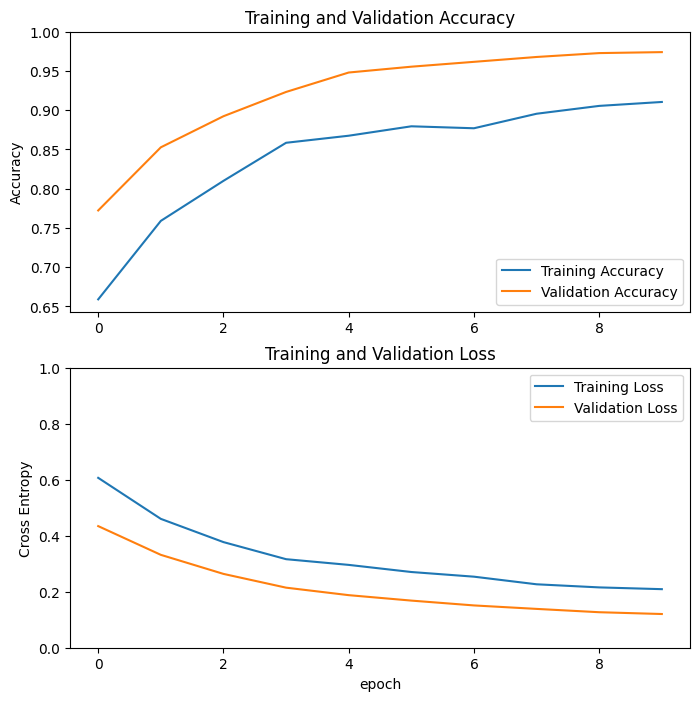

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

Another possibility to increase the performance even further is to fine-tune the weights of the top layers of the pre-trained model alongside the training of the classifier added. This will force the weights of a generic feature map to turn into a specifically feature map.

* This should only be attempted after the training the new classifier on top of the pre-trained non-trainable model. Training with a random initializaed classifier on top of a pre-trained model now trainable will make the magnitude of the gradient updates too large and the pre-trained model will forget what it has learned

## Unfreezing the top layers of the model

In [54]:
base_model.trainable = True

print('Number of layers in the base model: ', len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  155


## Compiling the model

In [55]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), 
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [57]:
len(model.trainable_variables)

58

## Continuing the previous training the model

In [58]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 34s 542ms/step - loss: 0.1601 - accuracy: 0.9325 - val_loss: 0.0593 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 40s 635ms/step - loss: 0.1221 - accuracy: 0.9415 - val_loss: 0.0451 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 44s 692ms/step - loss: 0.1122 - accuracy: 0.9505 - val_loss: 0.0391 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 42s 660ms/step - loss: 0.0989 - accuracy: 0.9650 - val_loss: 0.0351 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 41s 654ms/step - loss: 0.0932 - accuracy: 0.9595 - val_loss: 0.0430 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 40s 640ms/step - loss: 0.1011 - accuracy: 0.9555 - val_loss: 0.0393 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 41s 648ms/step - loss: 0.0796 - accuracy: 0.9650 - val_loss: 0.0325 - val_accuracy:

## Learning curves

In [59]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

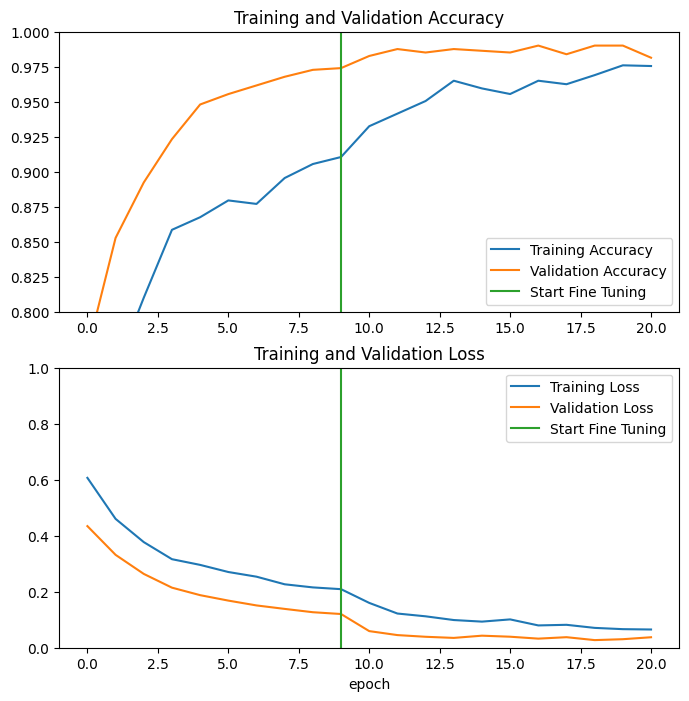

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [61]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 233ms/step - loss: 0.0497 - accuracy: 0.9844
Test accuracy : 0.984375


In [62]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions:
 [1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1]
Labels:
 [1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1]
